# Fashion Image Classification

Trabalho final da disciplina de Engenharia de Sistemas de Software Inteligentes do curso de Engenharia de Software da Pontifícia Universidade Católica do Rio de Janeiro (PUC-Rio).

## Descrição do Projeto

Este projeto é modelo de Machine Learning para classificação de imagens de moda. O objetivo é permitir que os usuários enviem imagens e recebam de volta a classificação correspondente.


### Aluno: Roberto da Costa

### Etapa 1: Importação das bibliotecas necessárias

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import pickle

from PIL import Image
import io

### Etapa 2: Carga do Dataset

In [2]:
url = "https://github.com/robertheory/mvp-essi/raw/refs/heads/master/ml/datasets/test.parquet"

dataset = pd.read_parquet(url)

# dataset muito grande, vamos usar apenas uma amostra de 10.000 linhas
dataset = dataset.sample(n=8000, random_state=42)

# Exibe as primeiras linhas do dataset
dataset.head()

,image,label
6252,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",6
4684,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,3
1731,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
4742,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,5
4521,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,2


### Etapa 3: Separação em Conjuntos (Holdout)

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Extrai os bytes das imagens e converte para arrays numpy
def bytes_to_array(img_bytes):
  img = Image.open(io.BytesIO(img_bytes))
  img = img.resize((64, 64))  # Redimensiona para 64x64 pixels
  return np.array(img).flatten()  # Achata para vetor 1D

X = np.stack(dataset['image'].apply(lambda x: bytes_to_array(x['bytes'])))
y = dataset['label'].values

# Separação dos dados em treino e teste (Holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 3

# Ajusta o número de partições para não exceder o número mínimo de amostras por classe
min_samples_per_class = np.min(np.bincount(y_train))
num_particoes = min(num_particoes, min_samples_per_class)
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Etapa 4: Criação e avaliação de modelos: linha base

SVM: 0.830471 (0.011069)


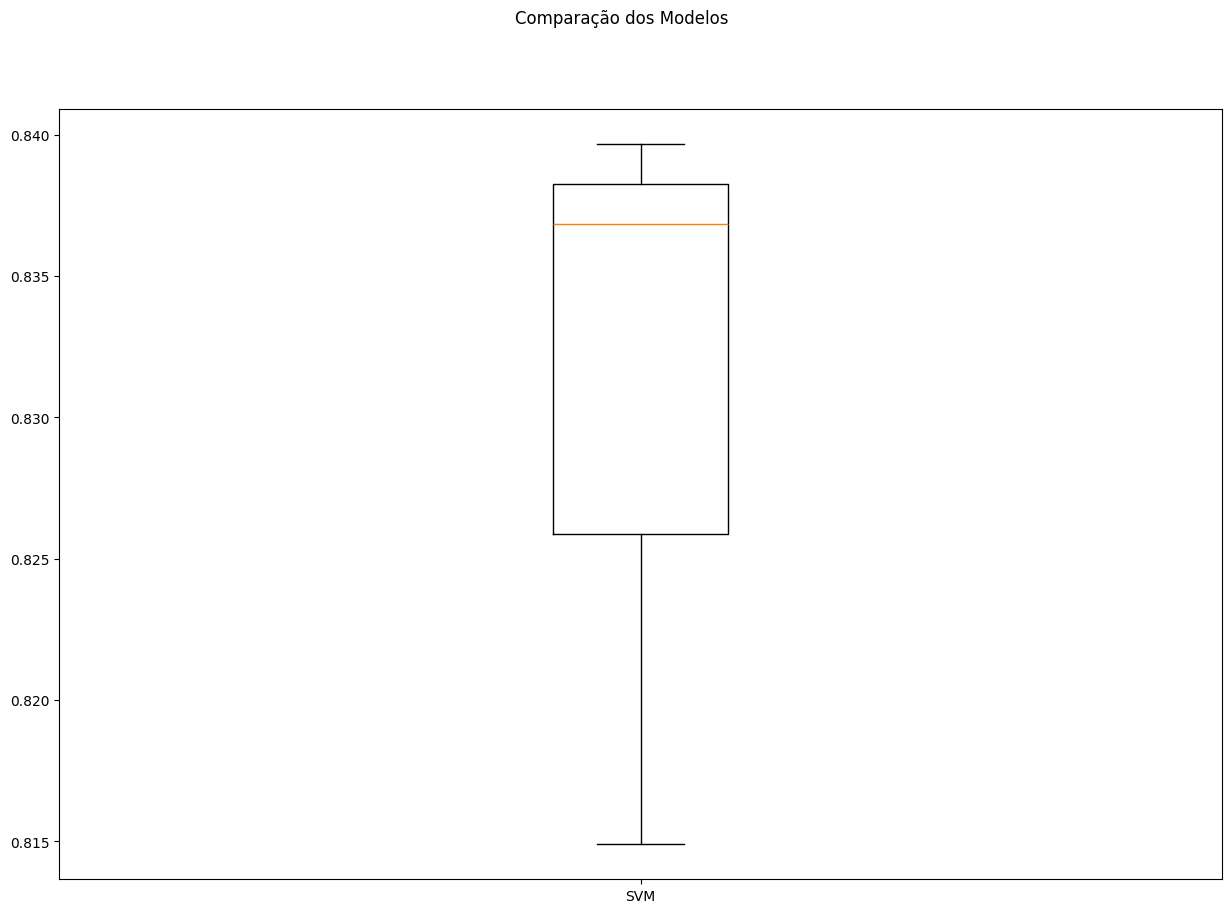

In [4]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Etapa 5: Criação e avaliação de modelos: dados padronizados e normalizados

SVM-orig: 0.830 (0.011)
SVM-padr: 0.832 (0.012)
SVM-norm: 0.831 (0.012)


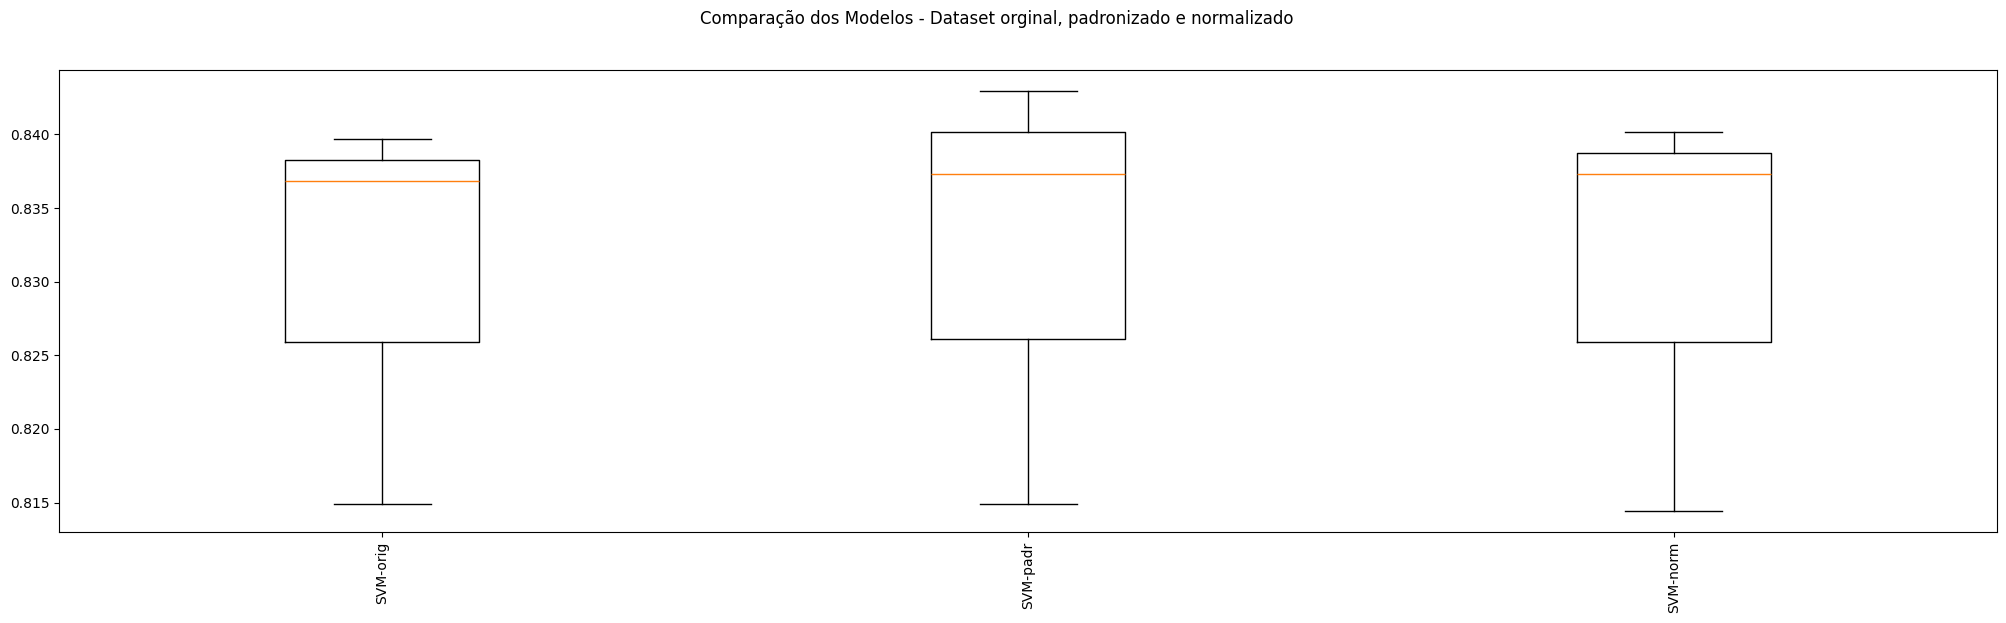

In [5]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
#pipelines.append(('KNN-orig', Pipeline([knn])))
#pipelines.append(('CART-orig', Pipeline([cart])))
#pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
#pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
#pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
#pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
#pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
#pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
#pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Etapa 6: Otimização dos hiperparâmetros

In [6]:
# Otimização dos hiperparâmetros para SVM padronizado usando GridSearchCV

# Pipeline com padronização e SVM
pipeline_svm = Pipeline([
  ('StandardScaler', standard_scaler[1]),
  ('SVM', SVC())
])

# Espaço de busca dos hiperparâmetros
param_grid = {
  'SVM__C': [0.1, 1, 10],
  'SVM__gamma': [0.001, 0.01, 0.1, 1],
  'SVM__kernel': ['rbf', 'linear']
}

# GridSearchCV
grid = GridSearchCV(estimator=pipeline_svm, param_grid=param_grid, cv=kfold, scoring=scoring, n_jobs=-1, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Exibe os melhores parâmetros e a melhor acurácia
print(f"Melhor acurácia: {grid_result.best_score_:.4f}")
print("Melhores parâmetros:", grid_result.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ...SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=linear; total time=  47.9s
[CV] END ...SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=linear; total time=  49.0s
[CV] END ...SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=linear; total time=  49.2s
[CV] END ....SVM__C=0.1, SVM__gamma=0.01, SVM__kernel=linear; total time=  44.6s
[CV] END ....SVM__C=0.1, SVM__gamma=0.01, SVM__kernel=linear; total time=  45.3s
[CV] END ....SVM__C=0.1, SVM__gamma=0.01, SVM__kernel=linear; total time=  44.8s
[CV] END ......SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=rbf; total time= 2.9min
[CV] END ......SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=rbf; total time= 3.0min
[CV] END ......SVM__C=0.1, SVM__gamma=0.001, SVM__kernel=rbf; total time= 3.0min
[CV] END .....SVM__C=0.1, SVM__gamma=0.1, SVM__kernel=linear; total time=  42.0s
[CV] END .....SVM__C=0.1, SVM__gamma=0.1, SVM__kernel=linear; total time=  42.7s
[CV] END .......SVM__C=0.1, SVM__gamma=0.01, SVM

### Etapa 7: Finalização do Modelo

In [7]:
# Treinando o modelo SVM com os melhores hiperparâmetros encontrados pelo GridSearchCV
best_svm = grid_result.best_estimator_
best_svm.fit(X_train, y_train)

# Avaliando no conjunto de teste
y_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {test_accuracy:.4f}")

Acurácia no conjunto de teste: 0.8275


In [8]:
# Treinando o modelo SVM otimizado com todo o dataset disponível (X, y)
final_model = grid_result.best_estimator_
final_model.fit(X, y)
print("Modelo final treinado com todo o dataset disponível.")

Modelo final treinado com todo o dataset disponível.


### Etapa 8: Simulando a aplicação do modelo em dados não vistos

Imagem: boot, Previsão: 8
Imagem: jacket, Previsão: 8
Imagem: jeans, Previsão: 8
Imagem: shirt, Previsão: 8
Imagem: short, Previsão: 8


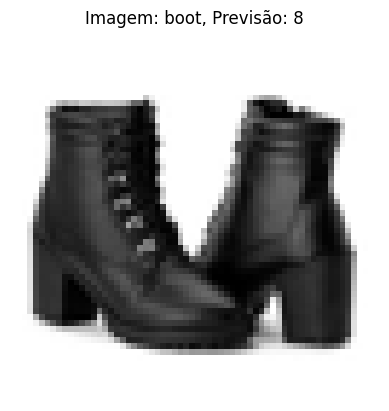

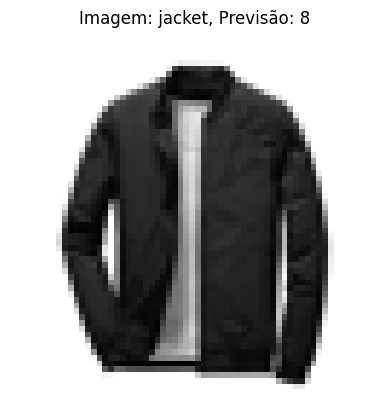

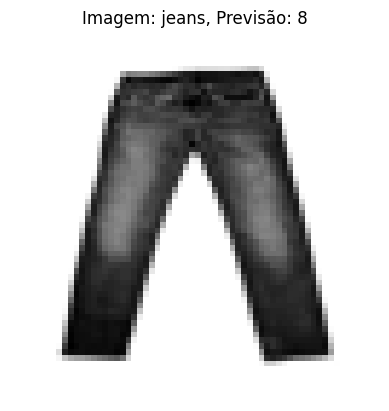

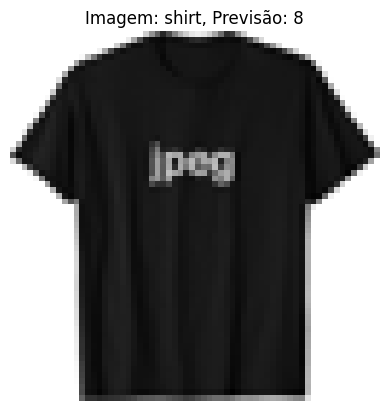

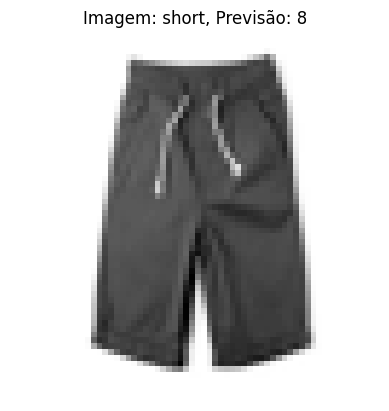

In [10]:
import requests
# Dicionário com os caminhos das imagens das roupas
flower_images = {
  'boot': 'https://github.com/robertheory/mvp-essi/blob/master/ml/imgs/boot.jpeg?raw=true',
  'jacket': 'https://github.com/robertheory/mvp-essi/blob/master/ml/imgs/jacket.jpg?raw=true',
  'jeans': 'https://github.com/robertheory/mvp-essi/blob/master/ml/imgs/jeans.jpg?raw=true',
  'shirt': 'https://github.com/robertheory/mvp-essi/blob/master/ml/imgs/shirt.jpeg?raw=true',
  'short': 'https://github.com/robertheory/mvp-essi/blob/master/ml/imgs/short.jpg?raw=true',
}

# Função para carregar e processar uma imagem
def load_and_preprocess_image(img_path):
  img = Image.open(io.BytesIO(requests.get(img_path).content))  # Carrega a imagem da URL
  img = img.resize((64, 64))
  img = img.convert('L') # Convert to grayscale
  return np.array(img).flatten()

# Carrega e processa as imagens das roupas
clothes_images = {label: load_and_preprocess_image(path) for label, path in flower_images.items()}

# Prepara os dados para a previsão
X_clothes = np.array(list(clothes_images.values()))
# Realiza a previsão usando o modelo treinado
predictions = final_model.predict(X_clothes)
# Exibe as previsões
for label, prediction in zip(clothes_images.keys(), predictions):
    print(f"Imagem: {label}, Previsão: {prediction}")

# Exibe as imagens e suas previsões
for label, img in clothes_images.items():
    plt.imshow(img.reshape(64, 64), cmap='gray')  # Redimensiona para 64x64 pixels and display as grayscale
    plt.title(f"Imagem: {label}, Previsão: {final_model.predict([img.flatten()])[0]}")
    plt.axis('off')
    plt.show()

### Etapa 9: Exportando o modelo para o formato PKL

In [11]:
# Nome do arquivo para salvar o modelo
filename = 'fashion_image_classification_model.pkl'

# Salvar o modelo no arquivo
pickle.dump(final_model, open(filename, 'wb'))

print(f"Modelo exportado para '{filename}'")

Modelo exportado para 'fashion_image_classification_model.pkl'
